In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter

In [79]:
def date_time_str_to_long(input_date_time_string):
    if input_date_time_string == 'None':
        return 0
    time_array = time.strptime(input_date_time_string, "%Y-%m-%d %H:%M:%S")
    time_stamp = int(time.mktime(time_array))
    return time_stamp


def load_csv_get_beta(filepath):
    df = pd.read_csv(filepath, header=None)
    df.columns = ['taskidname', 'taskid', 'type', 'value']
    return df


def get_running_time(df_data, task_num):
    res_list = []
    for i in range(task_num):
        start_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'start_time')]['value'].values[0]
        finish_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'finish_time')]['value'].values[0]
        res_list.append(finish_time - start_time)

    return res_list


def get_completion_time(df_data, task_num):
    res_list = []
    for i in range(task_num):
        arriving_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'arriving_time')]['value'].values[0]
        finish_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'finish_time')]['value'].values[0]
        res_list.append(finish_time - arriving_time)

    return res_list


def get_wait_time(df_data, task_num):
    res_list = []
    for i in range(task_num):
        arriving_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'arriving_time')]['value'].values[0]
        start_time = df_data.loc[(df_data['taskid'] == i) & (df_data['type'] == 'start_time')]['value'].values[0]
        res_list.append(start_time - arriving_time)

    return res_list

def get_comm_ratio(arch_name):
    df = pd.read_csv(f'{arch_name}/task_comm_ratio.txt', header=None)
    df.columns = ['taskid', 'exp', 'actual', 'ratio']
    df.sort_values(by='taskid', inplace=True)
    df['ratio'] = df['ratio'].apply(lambda x: 1.0 if -1e-3 < x - 1 < 1e-3 else x)
    return df['ratio'].values.tolist()

In [3]:
# 定义数据
num_tasks = 1000
task_nums = num_tasks
best = load_csv_get_beta(f'best/task_time.log')
lumoscore_2tau = load_csv_get_beta(f'lumoscore_tau_2/task_time.log')
lumoscore_1tau = load_csv_get_beta(f'lumoscore_tau_1/task_time.log')
lumoscore_25_6t = load_csv_get_beta(f'lumoscore_tau_1_26T/task_time.log')
clos = load_csv_get_beta(f'ele/task_time.log')
clos_4tier_25_6t = load_csv_get_beta(f'ele_4tier/task_time.log')
clos_3tier_25_6t = load_csv_get_beta(f'ele_26T/task_time.log')

In [4]:
# Colors and line styles for each architecture
colors = [(169/255, 111/255, 176/255), 
          (216/255, 160/255, 199/255), 
          (247/255, 167/255, 181/255), 
          (43/255, 48/255, 122/255), 
          (119/255, 194/255, 243/255), 
          (218/255, 226/255, 237/255)]
line_styles = ['-', '--', '-.', ':', '--', '-.']

In [5]:
architectures = {
    'LumosCore(2-$\\tau$)': lumoscore_2tau,
    'LumosCore(1-$\\tau$)': lumoscore_1tau,
    'LumosCore(25.6T)': lumoscore_25_6t,
    'Clos(51.2T)': clos,
    'Clos(4-tier,25.6T)': clos_4tier_25_6t,
    'Clos(3-tier,25.6T)': clos_3tier_25_6t,
}

## JRT

In [26]:
jrt_data = {k: get_running_time(v, task_nums) for k, v in architectures.items()}
best_jrt = np.array(get_running_time(best, task_nums))

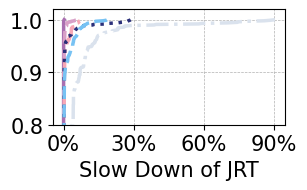

In [37]:
# Calculate drag factor for each architecture
drag_factors = {}
for key, jrt in jrt_data.items():
    drag_factor = jrt / best_jrt - 1
    drag_factors[key] = drag_factor * 100

# Create CDF plot
fig, ax = plt.subplots(figsize=(3, 1.5))
for i, (key, value) in enumerate(drag_factors.items()):
    sorted_data = np.sort(value)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    plt.plot(sorted_data, cdf, color=colors[i], linestyle=line_styles[i], linewidth=2.5)

# 设置横坐标为百分比格式
fmt = '%.0f%%' # 格式化为整数百分比
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
# ax.set_xscale('log')
plt.ylim(bottom=0.8, top=1.02)  # Set y-axis to start from 0.5
plt.xlabel('Slow Down of JRT', fontsize=15)  # Add x-axis label with font size
plt.yticks([0.8, 0.9, 1.0], fontsize=15)  # Set y-ticks and font size
plt.xticks([0, 30, 60, 90], fontsize=15)  # Set x-ticks font size
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines

# Save the CDF plot to a PDF file
plt.savefig('cdf_of_jrt.pdf', bbox_inches='tight')
plt.show()
plt.close()

## legend

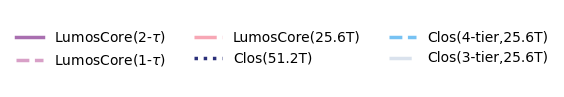

In [18]:
# Create legend plot
fig, ax = plt.subplots(figsize=(4, 1))
for i, key in enumerate(jrt_data.keys()):
    ax.plot([], [], color=colors[i], linestyle=line_styles[i], label=key, linewidth=2.5)

plt.legend(ncol=3, loc='center', fontsize=10, frameon=False)
ax.axis('off')  # Turn off axis

# Save the legend plot to a PDF file
plt.savefig('jrt_jwt_legend.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## JWT

In [19]:
jwt_data = {k: get_wait_time(v, task_nums) for k, v in architectures.items()}
best_jwt = np.array(get_wait_time(best, task_nums))

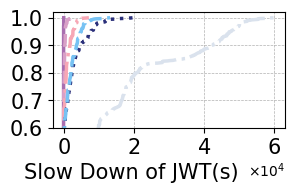

In [104]:
drag_factors = {}
for key, jwt in jwt_data.items():
    drag_factor = jwt - best_jwt
    drag_factors[key] = drag_factor

fig, ax = plt.subplots(figsize=(3, 1.5))
for i, (key, value) in enumerate(drag_factors.items()):
    sorted_data = np.sort(value)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    plt.plot(sorted_data, cdf, color=colors[i], linestyle=line_styles[i], linewidth=2.5)

# 设置横坐标为科学计数格式
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
ax.xaxis.set_major_formatter(formatter)

# ax.ticklabel_format(style='sci', scilimits=(-1,50), axis='x')
plt.ylim(bottom=0.6, top=1.02)  # Set y-axis to start from 0.5
plt.xlabel('Slow Down of JWT(s)       ', fontsize=15, loc='right')  # Add x-axis label with font size
plt.xticks(fontsize=15)  # Set x-ticks and font size
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=15)  # Set y-ticks and font size
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines

# Save the CDF plot to a PDF file
plt.savefig('cdf_of_jwt.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## JCT

In [ ]:
data = {
    '2k': [
        get_completion_time(lumoscore_2tau, task_nums),  # LumosCore(51.2T,2-$\tau$)
        get_completion_time(lumoscore_1tau, task_nums),  # LumosCore(51.2T,1-$\tau$)
        get_completion_time(lumoscore_25_6t, task_nums),  # LumosCore(25.6T,1-$\tau$)
        get_completion_time(clos, task_nums),  # Clos(51.2T,3Tier)
        get_completion_time(clos_4tier_25_6t, task_nums),  # Clos(25.6T,4Tier)
        get_completion_time(clos_3tier_25_6t, task_nums)   # Clos(25.6T,3Tier)
    ],
    '4k': [
        get_completion_time(lumoscore_2tau, task_nums),  # LumosCore(51.2T,2-$\tau$)
        get_completion_time(lumoscore_1tau, task_nums),  # LumosCore(51.2T,1-$\tau$)
        get_completion_time(lumoscore_25_6t, task_nums),  # LumosCore(25.6T,1-$\tau$)
        get_completion_time(clos, task_nums),  # Clos(51.2T,3Tier)
        get_completion_time(clos_4tier_25_6t, task_nums),  # Clos(25.6T,4Tier)
        get_completion_time(clos_3tier_25_6t, task_nums)   # Clos(25.6T,3Tier)
    ],
    '8k': [
        get_completion_time(lumoscore_2tau, task_nums),  # LumosCore(51.2T,2-$\tau$)
        get_completion_time(lumoscore_1tau, task_nums),  # LumosCore(51.2T,1-$\tau$)
        get_completion_time(lumoscore_25_6t, task_nums),  # LumosCore(25.6T,1-$\tau$)
        get_completion_time(clos, task_nums),  # Clos(51.2T,3Tier)
        get_completion_time(clos_4tier_25_6t, task_nums),  # Clos(25.6T,4Tier)
        get_completion_time(clos_3tier_25_6t, task_nums)   # Clos(25.6T,3Tier)
    ],
    '16k': [
        get_completion_time(lumoscore_2tau, task_nums),  # LumosCore(51.2T,2-$\tau$)
        get_completion_time(lumoscore_1tau, task_nums),  # LumosCore(51.2T,1-$\tau$)
        get_completion_time(lumoscore_25_6t, task_nums),  # LumosCore(25.6T,1-$\tau$)
        get_completion_time(clos, task_nums),  # Clos(51.2T,3Tier)
        get_completion_time(clos_4tier_25_6t, task_nums),  # Clos(25.6T,4Tier)
        get_completion_time(clos_3tier_25_6t, task_nums)   # Clos(25.6T,3Tier)
    ]
}

In [52]:
# 计算平均值
mean_data = {
    'Scale': [],
    'Architecture': [],
    'Mean_JCT': []
}

scales = ['2k', '4k', '8k', '16k']

for i, scale in enumerate(scales):
    for j, arch in enumerate(architectures):
        mean_jct = np.mean(data[scale][j])
        mean_data['Scale'].append(scale)
        mean_data['Architecture'].append(arch)
        mean_data['Mean_JCT'].append(mean_jct)

df_mean = pd.DataFrame(mean_data)

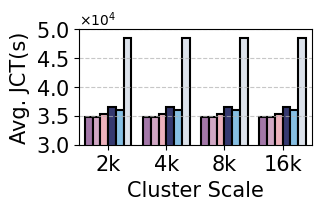

In [87]:
# 绘制条形图
plt.figure(figsize=(3, 1.5))
barplot = sns.barplot(x='Scale', y='Mean_JCT', hue='Architecture', data=df_mean, palette=colors, errorbar=None)

# 为每个条形添加边框以增加对比度
for bar in barplot.patches:
    bar.set_edgecolor('black')  # 设置边框颜色为黑色
    bar.set_linewidth(1.5)       # 设置边框宽度

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
barplot.yaxis.set_major_formatter(formatter)

# 添加网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 设置 X 轴、Y 轴标签和标题
plt.xlabel('Cluster Scale', fontsize=15)
plt.ylabel('Avg. JCT(s)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 移除图例
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([], [], frameon=False)
plt.ylim((30000,50000))
# 保存直方图为 diff_jct.pdf
plt.savefig('diff_jct.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Ratio

In [83]:
comm_ratio = {k:get_comm_ratio(k) for k in 
              ['best', 'lumoscore_tau_1', 'lumoscore_tau_2', 'lumoscore_tau_1_26T', 'ele', 'ele_26T', 'ele_4tier']}

In [ ]:
# Draw the comm_ratio figure
comm_ratio = {k:get_comm_ratio(k) for k in 
              ['best', 'lumoscore_tau_1', 'lumoscore_tau_2', 'lumoscore_tau_1_26T', 'ele', 'ele_26T', 'ele_4tier']}
df = pd.DataFrame(comm_ratio)

# Draw the percentage stack figure
fig, ax1 = plt.subplots(figsize=(3, 1.5))
#f.subplots_adjust(wspace=0.15)
sns.despine(fig)

ax1.set_xlabel("Percentage")
ax1.set_ylabel("Architecture")

# Draw stacked bar chart
df.plot.barh(stacked=True, ax=ax1, width=0.8, cmap=hotmap,  #edgecolor='black', linewidth=0.5)
             edgecolor="black", linewidth=0.5
             )

ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1))

ax1.set_xlim(-0.001, 0.35)
ax1.legend(ncol=2, **centering_legend(fig, extra_dispense=0.05))

# Disable ax2 legend
# Disable the spines and the grid
ax1.grid(False)
ax1.spines['left'].set_visible(False)
setup_borders(ax1, bottom=True)
set_grid(ax1, position="x", minor=True, major=True)
save_figure(fig, "ecmp_contention")

In [86]:
comm_ratio = pd.DataFrame(comm_ratio)
comm_ratio['best'].describe()

count    1000.000000
mean        1.029127
std         0.073968
min         1.000000
25%         1.000000
50%         1.000000
75%         1.016276
max         1.343629
Name: best, dtype: float64